In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('data/winequality-red.csv', sep=',')

In [12]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Ridge Coefficients: [ 0.04023522 -0.17924744 -0.0272208   0.00960154 -0.08902658  0.05783821
 -0.11985287 -0.01980983 -0.06018143  0.14678689  0.29607541]
SequentialFeatureSelector Selected Features: Index(['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol'], dtype='object')
SFS Lasso Coefficients: [-0.1443157  -0.          0.03307277  0.24768263]
RFE Selected Features: Index(['volatile acidity', 'pH', 'sulphates', 'alcohol'], dtype='object')
RFE Lasso Coefficients: [-0.14431584 -0.          0.03307281  0.2476826 ]
                                   Feature  Ridge Coefficients  \
fixed acidity                fixed acidity            0.040235   
volatile acidity          volatile acidity           -0.179247   
citric acid                    citric acid           -0.027221   
residual sugar              residual sugar            0.009602   
chlorides                        chlorides           -0.089027   
free sulfur dioxide    free sulfur dioxide            0.057838   
t

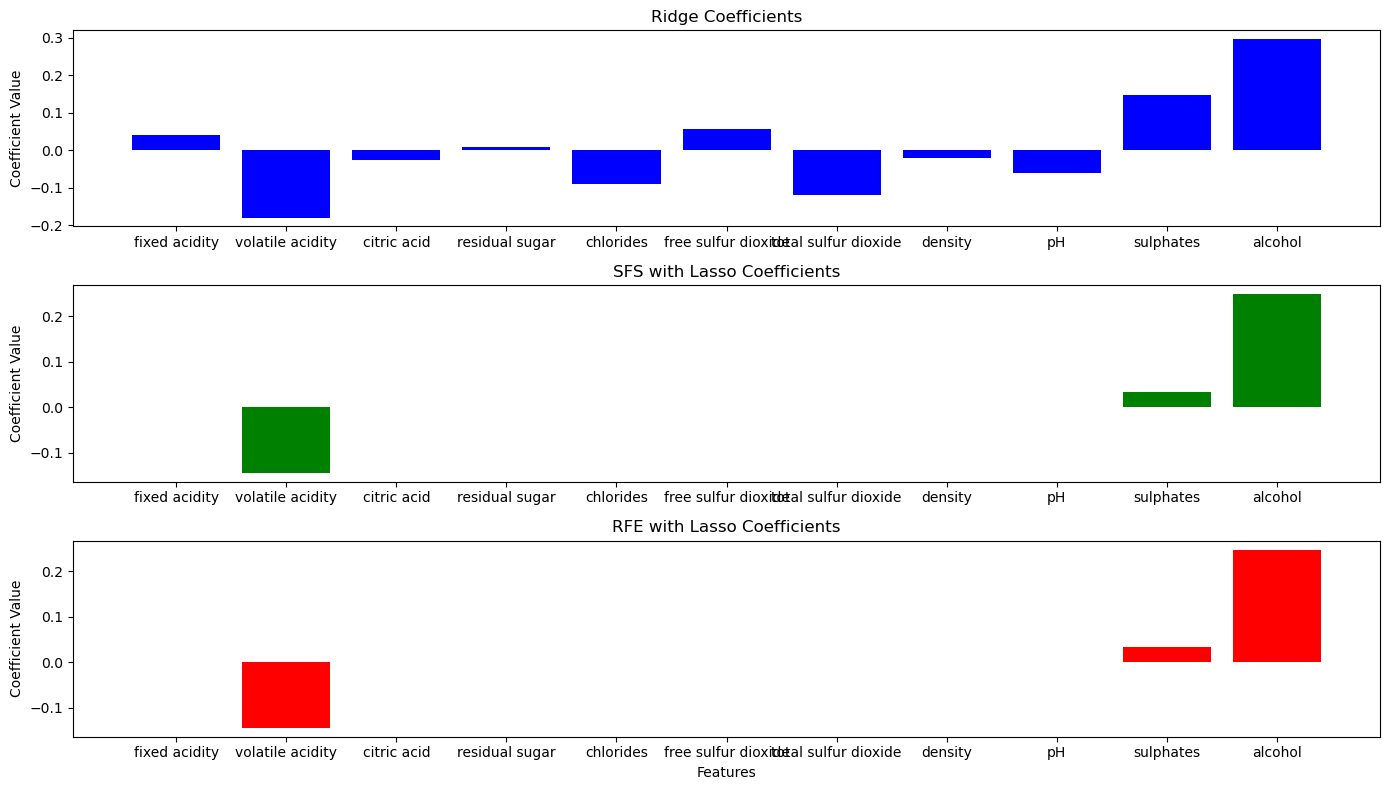

In [15]:
# Define features (X) and target (y)
X = data.drop(columns=['quality'])
y = data['quality']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Ridge regressor
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# Extract coefficients
ridge_coefficients = ridge.coef_
print("Ridge Coefficients:", ridge_coefficients)

# SequentialFeatureSelector with Lasso to select four features
lasso = Lasso(alpha=0.1)
sfs = SequentialFeatureSelector(lasso, n_features_to_select=4, direction='forward')
sfs.fit(X_train_scaled, y_train)

# Get the selected feature indices and names
sfs_selected_indices = sfs.get_support(indices=True)
sfs_selected_features = X.columns[sfs_selected_indices]
print("SequentialFeatureSelector Selected Features:", sfs_selected_features)

# Train a Lasso model using only the selected features
X_train_sfs = sfs.transform(X_train_scaled)
X_test_sfs = sfs.transform(X_test_scaled)
lasso.fit(X_train_sfs, y_train)
sfs_lasso_coefficients = lasso.coef_
print("SFS Lasso Coefficients:", sfs_lasso_coefficients)

# RFE with Lasso to select four features
lasso_rfe = Lasso(alpha=0.1)
rfe = RFE(lasso_rfe, n_features_to_select=4)
rfe.fit(X_train_scaled, y_train)

# Get the selected feature indices and names
rfe_selected_indices = rfe.get_support(indices=True)
rfe_selected_features = X.columns[rfe_selected_indices]
print("RFE Selected Features:", rfe_selected_features)

# Train a Lasso model using only the selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)
lasso_rfe.fit(X_train_rfe, y_train)
rfe_lasso_coefficients = lasso_rfe.coef_
print("RFE Lasso Coefficients:", rfe_lasso_coefficients)

# Prepare results for comparison
ridge_results = pd.Series(ridge_coefficients, index=X.columns, name='Ridge Coefficients')
sfs_results = pd.Series(np.zeros(len(X.columns)), index=X.columns, name='SFS Coefficients')
sfs_results[sfs_selected_features] = sfs_lasso_coefficients
rfe_results = pd.Series(np.zeros(len(X.columns)), index=X.columns, name='RFE Coefficients')
rfe_results[rfe_selected_features] = rfe_lasso_coefficients

results_df = pd.DataFrame({
    'Feature': X.columns,
    'Ridge Coefficients': ridge_results,
    'SFS Coefficients': sfs_results,
    'RFE Coefficients': rfe_results
})

print(results_df)

# Visualization
plt.figure(figsize=(14, 8))

# Ridge coefficients
plt.subplot(3, 1, 1)
plt.bar(results_df['Feature'], results_df['Ridge Coefficients'], color='blue')
plt.title('Ridge Coefficients')
plt.ylabel('Coefficient Value')

# SFS coefficients
plt.subplot(3, 1, 2)
plt.bar(results_df['Feature'], results_df['SFS Coefficients'], color='green')
plt.title('SFS with Lasso Coefficients')
plt.ylabel('Coefficient Value')

# RFE coefficients
plt.subplot(3, 1, 3)
plt.bar(results_df['Feature'], results_df['RFE Coefficients'], color='red')
plt.title('RFE with Lasso Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')

plt.tight_layout()
plt.show()
